## RECONSTRUCTION

In [1]:
import AnalogToDigital as ADC
import AnalogToDigital.deltaSigma as deltaSigma

import matplotlib
%matplotlib notebook
import matplotlib.pyplot as plt

import numpy as np
from scipy import signal
import _pickle as pickle
import os.path

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils import data
from torch.autograd import Variable

import AnalogToDigital as ADC

from __future__ import division
from deltasigma import *


%load_ext autoreload
%autoreload 2

/home/rakeusch/.conda/envs/rakeusch_3.6.5/lib/python3.6/site-packages/deltasigma/__init__.py:919: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/rakeusch/.conda/envs/rakeusch_3.6.5/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/rakeusch/.conda/envs/rakeusch_3.6.5/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/rakeusch/.conda/envs/rakeusch_3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/rakeusch/.conda/envs/rakeusch_3.6.5/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File

In [2]:
n_samples = 1 << 17   # number of sample pairs (x, y)
OSR = 32           # oversampling rate, must be integer
order_mash_block = [2,2,2]  # order of one mash block
order = len(order_mash_block)
n_lev = 2            # bit levels

# Expected Performance
systemOrder = np.sum(order_mash_block)
DR = 1 * 6.02 + 1.76 + 10 * np.log10(2 * systemOrder + 1) - 20 * systemOrder * np.log10(np.pi) + 10 * (2 * systemOrder + 1) * np.log10(OSR)
ENOB = (DR - 1.76) / 6.02
print('Expected MSE: %f\nEffective Number of bits: %s' % (-DR, ENOB))

Expected MSE: -154.930946
Effective Number of bits: 25.4436787344452


(array([], dtype=float64), array([], dtype=complex128), 1.0) (array([1., 1.]), array([0.61257411-0.25743231j, 0.61257411+0.25743231j]), 1.0)
(array([], dtype=float64), array([], dtype=complex128), 1.0) (array([1., 1.]), array([0.61257411-0.25743231j, 0.61257411+0.25743231j]), 1.0)
(array([], dtype=float64), array([], dtype=complex128), 1.0) (array([1., 1.]), array([0.61257411-0.25743231j, 0.61257411+0.25743231j]), 1.0)


/home/rakeusch/.conda/envs/rakeusch_3.6.5/lib/python3.6/site-packages/deltasigma/_realizeNTF.py:149: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  a = -np.real(np.linalg.lstsq(T.T, L1.T)[0]).T
/home/rakeusch/.conda/envs/rakeusch_3.6.5/lib/python3.6/site-packages/deltasigma/_simulateDSM.py:215: UserWarning: Using a slow implementation of simulateDSM
Refer to the docs for how to switch to a fast one
  'Refer to the docs for how to switch to a fast one')


TransferFunctionContinuous(
array([ 1., -2.,  1.]),
array([ 1.        , -1.22514823,  0.44151844]),
dt: None
)
[ 1.         -1.77485177  1.38402506 ...  0.01341353  1.98498116
  0.42597383]
TransferFunctionContinuous(
array([ 1., -4.,  6., -4.,  1.]),
array([ 1.        , -2.45029645,  2.38402506, -1.08185107,  0.19493853]),
dt: None
)
[ 1.00000000e+00 -2.54970355e+00  3.68445385e-01 ...  4.92550939e-14
  4.92550939e-14  4.92550939e-14]
TransferFunctionContinuous(
array([ 1., -2.,  1.]),
array([ 1.        , -1.22514823,  0.44151844]),
dt: None
)
[ 1.         -1.77485177 -0.61597494 ... -1.53606438 -0.600228
  1.94283248]
TransferFunctionContinuous(
array([ 1., -4.,  6., -4.,  1.]),
array([ 1.        , -2.45029645,  2.38402506, -1.08185107,  0.19493853]),
dt: None
)
[ 1.         -2.54970355  0.36844539 ... -1.46845095  2.65630335
 -2.20185995]
Offset due to filtering =  0
4.325118721279685e-10 4.3252570200950525e-10
MSE is -94.749308 dB
MSE with Correction is -94.816086 dB


/home/rakeusch/.conda/envs/rakeusch_3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py:85: RuntimeWarning: invalid value encountered in log10
/home/rakeusch/.conda/envs/rakeusch_3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py:86: RuntimeWarning: invalid value encountered in log10


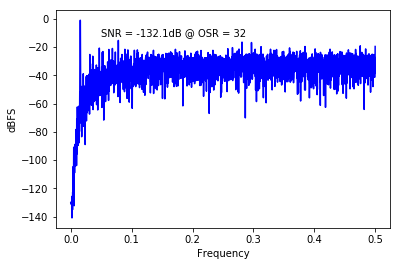

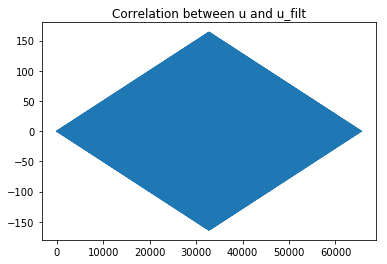

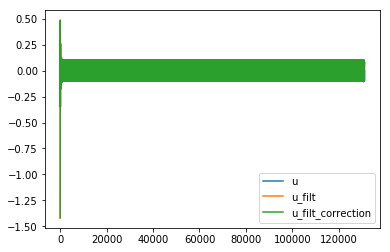

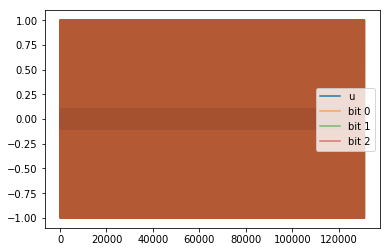

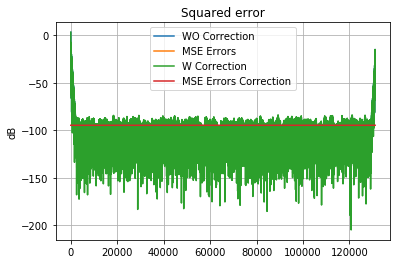

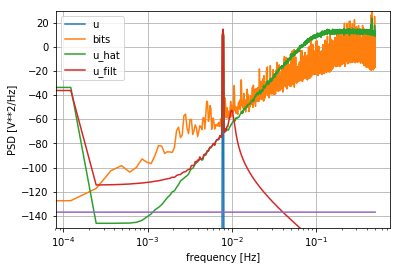

[0.00000000e+00 1.22070312e-04 2.44140625e-04 ... 4.99755859e-01
 4.99877930e-01 5.00000000e-01]


In [3]:

size = n_samples
fp = 500.
fp = 1./(OSR * 2) * 1./2.
Ts = 1.
# Ts = 1. / 2. / fp / OSR


dummy = np.zeros(order)
input = ADC.system.Sin(Ts, 0.1, fp , 0, steeringVector=dummy)
# input = ADC.system.BandlimitedNoise(0.9, 2 * OSR, 0)

t = np.linspace(0., Ts * (size - 1) , size)
u = input.scalarFunction(t)
# u = u - np.mean(u)

ds = [deltaSigma.DeltaSigma(OSR, x, nlev = n_lev) for x in order_mash_block]
mash = deltaSigma.MASH(OSR, ds)

# ds = deltaSigma.DeltaSigma(OSR, order, nlev = n_lev)


mash.simSpectrum()
bits = mash.simulate(input, t)

u_hat = mash.reconstruction(bits)

window = int(3/8. * u.size)

# find offset
plt.figure()
plt.title("Correlation between u and u_filt")
corr = np.correlate(u[window:-window], u_hat[window:-window], 'full')
offset = int(len(corr)/2) - np.argmax(corr)
plt.plot(corr)
print("Offset due to filtering = ", offset)

u_hat = np.roll(u_hat, -offset)
    
# filter noise-shaped mash output signal
u_filt = u_hat.copy()
f3dB = 1./(OSR) 
# b, a = signal.iirfilter(16, f3dB, btype='lowpass', analog=False, ftype='butter')

N = 18
wp = f3dB
ws = (1. + 0.1) * wp
gpass = 0.01
gstopp = DR
sos = signal.iirfilter(N, wp, rs = gstopp, btype='lowpass', analog=False, ftype='cheby2', output="sos")


n_filter_applied = 1
for ii in range(n_filter_applied):
#     u_filt = mash.lowPassFilter(u_filt)
#     u_filt = signal.filtfilt(b, a, u_filt)
#     u_filt = signal.sosfilt(sos, u_filt)
    u_filt = signal.sosfiltfilt(sos, u_filt)

    
    
correction = np.dot(u[window:-window], u_filt[window:-window]) / (np.linalg.norm(u_filt[window:-window])**2)

u_filt_correction = u_filt * correction

plt.figure()
plt.plot(u, label="u")
plt.plot(u_filt, label="u_filt")
plt.plot(u_filt_correction, label="u_filt_correction")
plt.legend()

plt.figure()
plt.plot(u, label="u")
for ii in range(order):
    plt.plot(bits[:,ii], label = "bit %i" % ii, alpha=0.6)
#     break
plt.legend()


# Squared Error Plot
plt.figure()
error_abs = np.abs(u - u_filt)**2
error_abs -= np.mean(u-u_filt)**2
error_abs_correction = np.abs(u - u_filt_correction)**2
plt.plot(10 * np.log10(error_abs), label="WO Correction")
plt.plot(np.ones(u.size) * 10 * np.log10(np.sum(error_abs[window:-window])/error_abs[window:-window].size), label="MSE Errors")
plt.plot(10 * np.log10(error_abs_correction), label="W Correction")
plt.plot(np.ones(u.size) * 10 * np.log10(np.sum(error_abs_correction[window:-window])/error_abs[window:-window].size), label="MSE Errors Correction")
plt.grid(True)
plt.legend()
plt.ylabel("dB")
plt.title("Squared error")

length = u[window:-window].size
error = u[window:-window] - u_filt[window:-window]
error_correction = u[window:-window] - u_filt_correction[window:-window]

print(error.mean(), error_correction.mean())

error -= error.mean()
error_correction -= error_correction.mean()

mse = np.sum(np.abs(error)**2)
mse_correction = np.sum(np.abs(error_correction)**2)
mse /= length
mse_correction /= length

print("MSE is %f dB" % (10 * np.log10(mse)))
print("MSE with Correction is %f dB" % (10 * np.log10(mse_correction)))




# plot psd of input signal
f, psd_u = signal.welch(u, 1, nperseg=1024 * 8)
f, psd_bits = signal.welch(bits[:,0], 1, nperseg=1024 * 8)
f, psd_u_hat = signal.welch(u_hat, 1, nperseg=1024 * 8)
f, psd_u_filt = signal.welch(u_filt_correction, 1, nperseg=1024 * 8)


plt.figure()
plt.grid(True)
plt.semilogx(f, 10 * np.log10(psd_u), label='u')
plt.semilogx(f, 10 * np.log10(psd_bits), label='bits')
plt.semilogx(f, 10 * np.log10(psd_u_hat), label='u_hat')
plt.semilogx(f, 10 * np.log10(psd_u_filt), label='u_filt')
plt.semilogx(f, np.ones_like(f) * 10 * np.log10(10**(-DR/10.) * (OSR * 2)))
# for index in range(1, systemOrder + 1):
#     offset = 1 * 6.02 + 1.76 + 10 * np.log10(2 * index + 1) - 20 * index * np.log10(np.pi)
#     plt.semilogx(f, offset + 10 * (2 * index + 1) * np.log10(OSR), label="order %i" % (index ))

plt.ylim([-150, 30])
# plt.xlim([0,0.1])
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.legend()
plt.show()

print(f)